In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### READING ANIMELIST.CSV

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

#### DATA PROCESSING

In [8]:
n_ratings = rating_df["user_id"].value_counts()
# Keep only users with at least 400 ratings --> get active users to improve model quality
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [9]:
len(rating_df)

3246641

In [10]:
min_rating =min(rating_df["rating"])
min_rating

0

In [11]:
max_rating =max(rating_df["rating"])

In [12]:
max_rating

10

In [ ]:
# average rating for all user-anime pairs, we will use it to normalize the ratings later
avg_rating =np.mean(rating_df["rating"])

In [14]:
avg_rating

np.float64(4.122732695114736)

In [15]:
# Normalize ratings to range [0, 1] for better training stability
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [16]:
rating_df.duplicated().sum()

np.int64(0)

In [17]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
# Encode user ids to sequential integers
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)} # Map original user_id to encoded integer
user2user_decoded = {i : x for i , x in enumerate(user_ids)} # Map encoded integer back to original user_id
rating_df["user"] = rating_df["user_id"].map(user2user_encoded) # Add new column with encoded user ids

In [19]:
n_users = len(user2user_encoded)

In [20]:
n_users

4203

In [21]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [22]:
# Encode anime ids to sequential integers
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)} # Map original anime_id to encoded integer
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)} # Map encoded integer back to original anime_id
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded) # Add new column with encoded anime ids

In [23]:
n_anime = len(anime2anime_encoded)

In [24]:
n_anime

17149

In [25]:
# Shuffle the dataset
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [26]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [27]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [28]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [29]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [30]:
len(X_train)

3245641

In [31]:
len(X_test)

1000

In [32]:
type(X_train)

numpy.ndarray

In [33]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [34]:
type(X_test_array)

list

In [35]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [ ]:
# Define the RecommenderNet model architecture (including embeddings and dot product for similarity calculation)
def RecommenderNet():
    embedding_size =128

    # input layer 1
    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    # input layer 2
    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    # dot product to get similarity score between user and anime (by comparing their embeddings)
    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    # convert into a single dimension
    x = Flatten()(x)

    # fully connected layer to learn complex interactions
    ## kernel_initializer helps with weight initialization for better convergence, he_normal is a good choice for layers with ReLU activations
    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    # define and compile the model
    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [37]:
model = RecommenderNet()

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [39]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# learning rate scheduler function
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr # Linear ramp-up
    elif epoch<ramup_epochs+sustain_epochs: # Sustain phase
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr # Exponential decay

In [ ]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [41]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [ ]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,# display progress bar
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.6990 - mae: 0.3624 - mse: 0.1584 - val_loss: 0.6930 - val_mae: 0.3611 - val_mse: 0.1557 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.6975 - mae: 0.3620 - mse: 0.1577 - val_loss: 0.6942 - val_mae: 0.3621 - val_mse: 0.1563 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.6953 - mae: 0.3614 - mse: 0.1566 - val_loss: 0.6949 - val_mae: 0.3626 - val_mse: 0.1566 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.6928 - mae: 0.3607 - mse: 0.1554 - val_loss: 0.6936 - val_mae: 0.3623 - val_mse: 0.1560 - learning_rate: 3.4000e-05


In [43]:
model.load_weights(checkpoint_filepath)

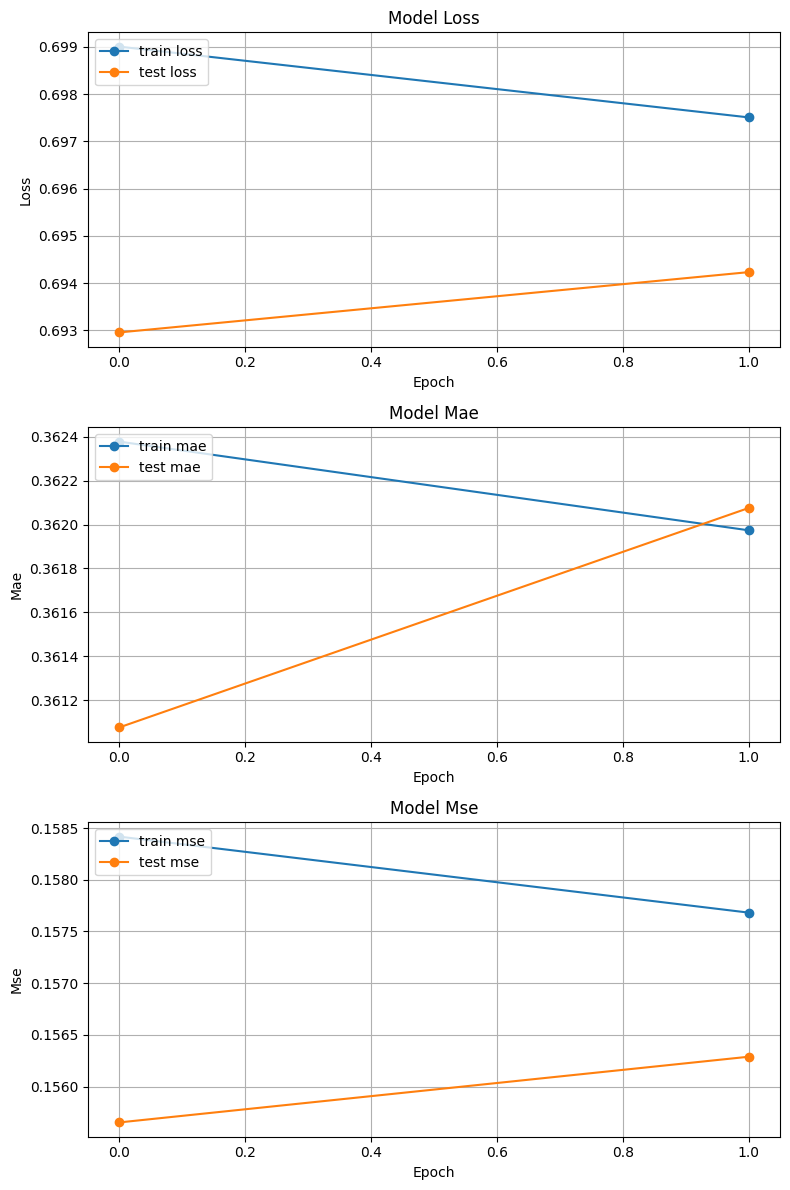

In [44]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to extract and normalize weights from a specified layer
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0] # Get weights from the layer ([0] is for weights, [1] would be for biases)
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1)) # Normalize weights using L2 norm --> use for cosine similarity
    return weights

In [ ]:
anime_weights = extract_weights("anime_embedding", model) # Extract and normalize anime embedding weights

In [ ]:
user_weights = extract_weights("user_embedding", model) # Extract and normalize user embedding weights

#### READING ANIME.CSV

In [ ]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [ ]:
# Replace "Unknown" with NaN for better handling of missing values
df = df.replace("Unknown",np.nan)

In [ ]:
# Function to get anime name by anime_id (tries to get English version first, falls back to original name if English version is not available)
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [51]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [52]:
getAnimeName(6702)

'Fairy Tail'

In [ ]:
# sort anime dataframe by Score in descending order for better recommendation display
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [54]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [55]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [56]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [57]:
# Function to get anime dataframe by anime_id or anime name (returns all matching rows if anime name is given)
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [58]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [ ]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [ ]:
cols = ["MAL_ID", "Name", "Genres", "synopsis"]

In [61]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [62]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [63]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [ ]:
# Function to get anime synopsis by anime_id or anime name (returns the synopsis string)
def getSynopsis(anime, synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].synopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].synopsis.values[0]

In [65]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [66]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [ ]:
pd.set_option("max_colwidth", None) # Set pandas option to display full text in columns

In [ ]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    """
    Find similar animes based on cosine similarity of embeddings.
    Parameters:
    - name: str, name of the anime to find similarities for
    - anime_weights: np.ndarray, normalized embedding weights for animes
    - anime2anime_encoded: dict, mapping from original anime_id to encoded integer
    - anime2anime_decoded: dict, mapping from encoded integer back to original anime_id
    - df: pd.DataFrame, dataframe containing anime information
    - synopsis_df: pd.DataFrame, dataframe containing anime synopses
    - n: int, number of similar animes to return
    - return_dist: bool, whether to return similarity distances along with indices
    - neg: bool, if True, return least similar animes instead of most similar
    Returns:
    - pd.DataFrame of similar animes with columns: name, similarity, genre
    """
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists) # Sort distances to get indices of similar animes

    n = n + 1 # Adjust n to account for the input anime itself

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   
        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       
    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [69]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Akindo Sei no Little Peso,0.352986,"Sci-Fi, Comedy"
8,Kick Off (2002),0.311808,Sports
7,Maken-Ki! Two,0.306834,"Action, Harem, Super Power, Ecchi, Martial Arts, School"
6,Barnacle Lou,0.304799,Kids
5,Ikusa Otome Valkyrie 2,0.293543,"Demons, Fantasy, Hentai, Supernatural"
4,Himitsukessha Taka no Tsume GT,0.290267,"Comedy, Parody, Super Power"
3,Mei Chuxi de Yinyangshi Yijia 2,0.289491,"Slice of Life, Comedy, Historical, Demons, Supernatural"
2,Detroit Metal City:Birth of the Metal Devil,0.287939,"Parody, Comedy, Romance, Music"
1,Wu Geng Ji,0.284089,"Action, Historical, Supernatural, Martial Arts, Fantasy"
0,Nekojiru Gekijou Jirujiru Original,0.280227,"Action, Comedy"


### USER BASED RECOMMENDATION

In [ ]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    """
    Find similar users based on cosine similarity of embeddings.
    Parameters:
    - item_input: int, user_id of the user to find similarities for
    - user_weights: np.ndarray, normalized embedding weights for users
    - user2user_encoded: dict, mapping from original user_id to encoded integer
    - user2user_decoded: dict, mapping from encoded integer back to original user_id
    - n: int, number of similar users to return
    - return_dist: bool, whether to return similarity distances along with indices
    - neg: bool, if True, return least similar users instead of most similar
    Returns:
    - pd.DataFrame of similar users with columns: similar_users, similarity
    """
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index]) # Ensure weights[encoded_index] is a 1D array
        sorted_dists = np.argsort(dists)  # Sort distances to get indices of similar users

        n=n+1 # want to include the user itself

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        # Create a DataFrame with results and sort by similarity
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occurred", e)  

In [71]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,745,0.326328
8,6382,0.320671
7,8966,0.317670
6,1187,0.311492
5,1002,0.304121
4,13686,0.285379
3,2414,0.281250
2,8468,0.273623
1,10958,0.264702
0,8653,0.262511


In [ ]:
def showWordCloud(all_genres):
    """
    Generate and display a word cloud from genre frequency data.
    Parameters:
    - all_genres: dict, frequency data for genres
    Returns:
    - Displays a word cloud plot    
    """
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres) # Generate word cloud from frequencies
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [73]:
from collections import defaultdict

In [74]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [75]:
def getFavGenre(frame , plot=False):
    """
    Analyze favorite genres from the anime dataframe and optionally plot a word cloud.
    Parameters:
    - frame: pd.DataFrame, dataframe containing anime information with a 'Genres' column
    - plot: bool, whether to display a word cloud of genre frequencies
    Returns:
    - genres_list: list, list of all genres found in the dataframe
    """
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [ ]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [ ]:
def get_user_preferences(user_id , rating_df , df ,plot=False):
    """
    Analyze a user's favorite genres based on their high-rated animes.
    Parameters:
    - user_id: int, ID of the user to analyze
    - rating_df: pd.DataFrame, dataframe containing user ratings
    - df: pd.DataFrame, dataframe containing anime information
    - plot: bool, whether to display a word cloud of favorite genres
    Returns:
    - pd.DataFrame of user's favorite animes with columns: eng_version, Genres
    """

    animes_watched_by_user = rating_df[rating_df.user_id == user_id] # Get all animes watched by the user

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75) # Calculate 75th percentile of user's ratings

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile] # Filter animes with ratings above the 75th percentile

    # Get top animes sorted by rating
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows

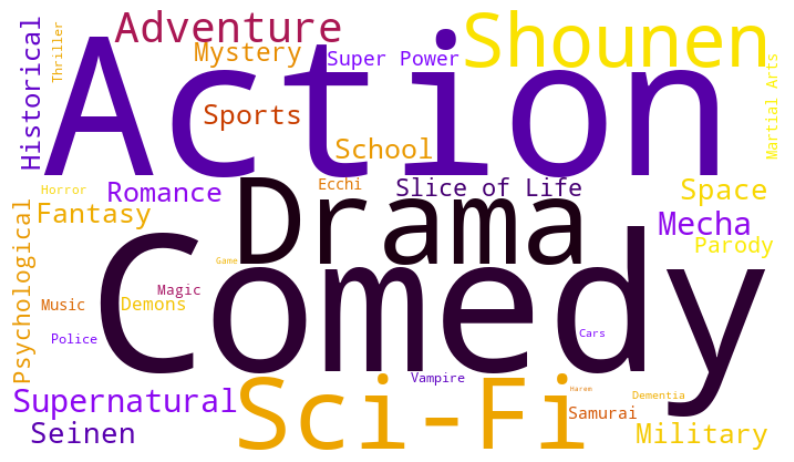

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [78]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [79]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):
    """
    Generate anime recommendations for a user based on similar users' preferences.
    Parameters:
    - similar_users: pd.DataFrame, dataframe containing similar users with columns: similar_users, similarity
    - user_pref: pd.DataFrame, dataframe containing the user's preferred animes with columns: eng_version, Genres
    - df: pd.DataFrame, dataframe containing anime information
    - synopsis_df: pd.DataFrame, dataframe containing anime synopses
    - rating_df: pd.DataFrame, dataframe containing user ratings
    - n: int, number of recommendations to return
    Returns:
    - pd.DataFrame of recommended animes with columns: n, anime_name, Genres, Synopsis
    """
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)

In [83]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
similar_users

,similar_users,similarity
9,745,0.326328
8,6382,0.320671
7,8966,0.317670
6,1187,0.311492
5,1002,0.304121
4,13686,0.285379
3,2414,0.281250
2,8468,0.273623
1,10958,0.264702
0,8653,0.262511


In [84]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)
user_pref

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [82]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,8,Attack on Titan Season 2,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","For centuries, humanity has been hunted by giant, mysterious predators known as the Titans. Three mighty walls—Wall Maria, Rose, and Sheena—provided peace and protection for humanity for over a hundred years. That peace, however, was shattered when the Colossus Titan and Armored Titan appeared and destroyed the outermost wall, Wall Maria. Forced to retreat behind Wall Rose, humanity waited with bated breath for the Titans to reappear and destroy their safe haven once more. In Shingeki no Kyojin Season 2 , Eren Yeager and others of the 104th Training Corps have just begun to become full members of the Survey Corps. As they ready themselves to face the Titans once again, their preparations are interrupted by the invasion of Wall Rose—but all is not as it seems as more mysteries are unraveled. As the Survey Corps races to save the wall, they uncover more about the invading Titans and the dark secrets of their own members."


### HYBRID RECOMMENDER SYSTEM

In [ ]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):
    """
    Generate hybrid anime recommendations combining user-based and content-based approaches.
    Parameters:
    - user_id: int, ID of the user to generate recommendations for
    - user_weight: float, weight for user-based recommendations
    - content_weight: float, weight for content-based recommendations
    Returns:
    - list of top 10 recommended anime names
    """
    # User Recommendation
    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist() # Get list of recommended anime names
    print(user_recommended_anime_list)

    # Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    # Combine scores from user-based and content-based recommendations
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [86]:
hybrid_recommendation(11880)

['Attack on Titan Season 2', 'Spirited Away', 'Your Name.', 'A Silent Voice', "Howl's Moving Castle", 'Made in Abyss', 'Attack on Titan', 'anohana:The Flower We Saw That Day', 'The Pet Girl of Sakurasou', 'Noragami Aragoto']


['Shu Ling Ji 2nd Season',
 'Attack on Titan Season 2',
 'Spirited Away',
 'Your Name.',
 'A Silent Voice',
 "Howl's Moving Castle",
 'Made in Abyss',
 'Attack on Titan',
 'anohana:The Flower We Saw That Day',
 'The Pet Girl of Sakurasou']